In [136]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/churn-modelling/Churn_Modelling.csv


In [137]:
from matplotlib import pyplot as plt
import seaborn as sns
churn = pd.read_csv('/kaggle/input/churn-modelling/Churn_Modelling.csv')
churn

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [138]:
from sklearn.model_selection import train_test_split
churn, churn_test = train_test_split(churn, test_size=0.25, random_state=42) #3/4 training and 1/4 testing

**Exploratory Data Analysis/AB Testing Phase**

Let's examine the distribution of credit scores. Could it be that credit score could be a reason why people closed their bank accounts in this particular bank.

The average credit score amongst those who closed their bank account is 647.0623376623377
The average credit score amongst those who did not close their bank account is 653.2548657718121


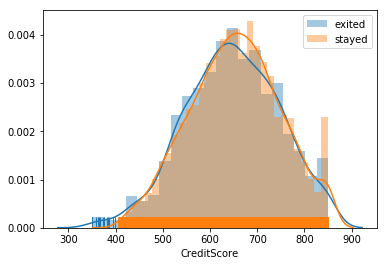

In [139]:
exited = churn[churn['Exited'] == 1]
stayed = churn[churn['Exited'] == 0]
sns.distplot(exited['CreditScore'], kde = True, rug = True, label = 'exited')
sns.distplot(stayed['CreditScore'], kde = True, rug = True, label = 'stayed')
plt.legend()
print('The average credit score amongst those who closed their bank account is', np.mean(exited['CreditScore'])) 
print('The average credit score amongst those who did not close their bank account is', np.mean(stayed['CreditScore'])) 

The distribution of credit scores is unimodal and roughly symmetric. There doesn't appear to be a significant difference in credit score amongst those who closed their bank account and did not close their bank account.

44.736363636363635
37.36442953020134


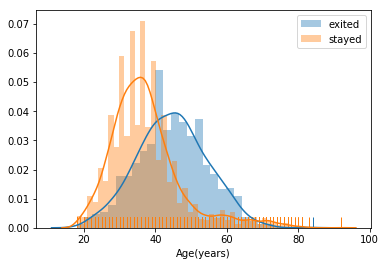

In [140]:
sns.distplot(exited['Age'], kde = True, rug = True, label = 'exited')
sns.distplot(stayed['Age'], kde = True, rug = True, label = 'stayed')
plt.xlabel('Age(years)')
plt.legend()
print(np.mean(exited['Age']))
print(np.mean(stayed['Age']))

Both distributions are unimodal and roughly symmetric. However, the distribution of age for the clients who exited is shifted to the right of the distribution of age for clients who stayed. Could it be that those who exited(closed their bank account) are on average older than those who stayed(didn't close their bank account)?

In [141]:
average_age_per_exit = churn[['Exited', 'Age']].groupby('Exited', as_index = False).agg(np.mean)
average_age_per_exit

,Exited,Age
0,0,37.364430
1,1,44.736364


Let's calculate the test statistic which is the average age of those who closed their bank accounts - average age of those who didn't close their bank accounts.

In [142]:
observed_difference = average_age_per_exit['Age'][1] - average_age_per_exit['Age'][0]
observed_difference

7.371934106162293

Null Hypothesis: The ages of those who exited(closed their bank accounts) and the ages of those who did not exit(didn't close their bank accounts) come from the same underlying distribution. There is no difference in average age between those who closed their bank accounts and didn't close their bank accounts in the population of customer churn in this bank.

Alternative Hypothesis: The ages of those who exited(closed their bank accounts) and the ages of those who did not exit(didn't close their bank accounts) come from different distributions. The average age of those who closed their bank accounts is greater than the average age of those who didn't close their bank accounts in the population of customer churn in this bank.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Text(0, 0.5, "Percent per Average Age of those who exited minus Average age of those who didn't exit")

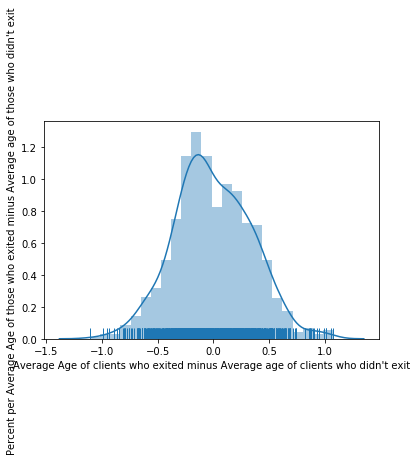

In [143]:
num_iterations = 1000
simulated_test_statistic_values = np.empty(num_iterations)
for i in np.arange(num_iterations):
    shuffled_exited = churn.sample(len(churn), replace = False).iloc[:, 13].to_frame().reset_index(drop=True)
    churn['Shuffled Exited'] = shuffled_exited['Exited']
    grouped_age = churn[['Shuffled Exited', 'Age']].groupby('Shuffled Exited').agg(np.mean)
    simulated_test_statistic_value = grouped_age['Age'][1] - grouped_age['Age'][0]
    simulated_test_statistic_values[i] = simulated_test_statistic_value
simulated_test_statistic_values = pd.Series(simulated_test_statistic_values)
sns.distplot(simulated_test_statistic_values, kde = True, rug = True)
plt.xlabel("Average Age of clients who exited minus Average age of clients who didn't exit")
plt.ylabel("Percent per Average Age of those who exited minus Average age of those who didn't exit")

In [144]:
p_value = np.count_nonzero(simulated_test_statistic_values >= observed_difference)/len(simulated_test_statistic_values)
p_value

0.0

With a small p-value of 0.0 which is less than the p-value cutoff of 0.05, we reject the null hypothesis. There is sufficient evidence to conclude that the ages of those who exited(closed their bank accounts) and the ages of those who did not exit(didn't close their bank accounts) come from different distributions. The average age of those who closed their bank accounts is greater than the average age of those who didn't close their bank accounts in the population of customer churn in this bank.

The average price balance amongst those who closed their bank account is 120426.45848068672
The average price balance amongst those who did not close their bank account is 119604.57422277634


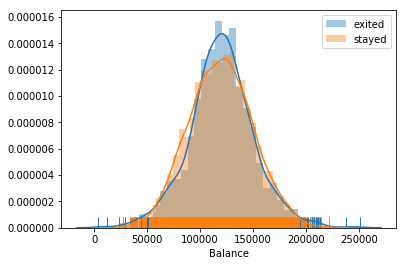

In [145]:
sns.distplot(exited[exited['Balance'] > 0]['Balance'], kde = True, rug = True, label = 'exited')
sns.distplot(stayed[stayed['Balance'] > 0]['Balance'], kde = True, rug = True, label = 'stayed')
plt.legend()
print('The average price balance amongst those who closed their bank account is', np.mean(exited[exited['Balance'] > 0]['Balance'])) 
print('The average price balance amongst those who did not close their bank account is', np.mean(stayed[stayed['Balance'] > 0]['Balance'])) 

There doesn't appear to be a significant difference in average balance between those who closed their bank accounts and those who didn't close their bank accounts.

The average estimated salary amongst those who closed their bank account is 101930.23279870137
The average estimated salary amongst those who did not close their bank account is 100342.01985067115


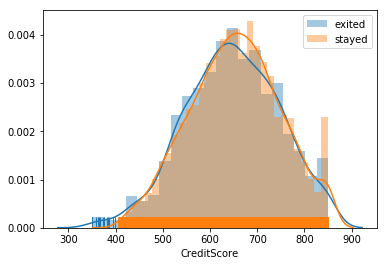

In [146]:
sns.distplot(exited['CreditScore'], kde = True, rug = True, label = 'exited')
sns.distplot(stayed['CreditScore'], kde = True, rug = True, label = 'stayed')
plt.legend()
print('The average estimated salary amongst those who closed their bank account is', np.mean(exited['EstimatedSalary'])) 
print('The average estimated salary amongst those who did not close their bank account is', np.mean(stayed['EstimatedSalary'])) 

Could it be that the average salary amongst those who closed their bank account is larger than the estimated salary amongst those who didn't close their bank account

In [147]:
average_estimated_salary_per_exit = churn[['Exited', 'EstimatedSalary']].groupby('Exited', as_index = False).agg(np.mean)
average_estimated_salary_per_exit

,Exited,EstimatedSalary
0,0,100342.019851
1,1,101930.232799


In [148]:
observed_difference = average_estimated_salary_per_exit['EstimatedSalary'][1] - average_estimated_salary_per_exit['EstimatedSalary'][0]
observed_difference

1588.2129480302247

Null Hypothesis: The estimated salaries of those who exited(closed their bank accounts) and the estimated salaries of those who did not exit(didn't close their bank accounts) come from the same underlying distribution. There is no difference in average estimated salary between those who closed their bank accounts and didn't close their bank accounts in the population of customer churn in this bank.

Alternative Hypothesis: The estimated salaries of those who exited(closed their bank accounts) and the estimated salaries of those who did not exit(didn't close their bank accounts) come from different distributions. The average estimated salary of those who closed their bank accounts is greater than the average estimated salary of those who didn't close their bank accounts in the population of customer churn in this bank.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Text(0, 0.5, "Percent per Average Estimated Salary of clients who exited minus Average Estimated Salary of clients who didn't exit")

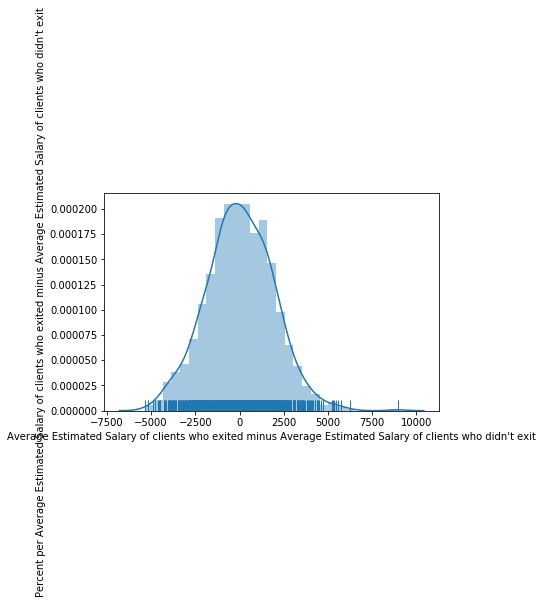

In [149]:
num_iterations = 1000
simulated_test_statistic_values = np.empty(num_iterations)
for i in np.arange(num_iterations):
    shuffled_exited = churn.sample(len(churn), replace = False).iloc[:, 13].to_frame().reset_index(drop=True) #So index in the new table isn't matched accordingly.
    churn['Shuffled Exited'] = shuffled_exited['Exited']
    grouped_estimated_salary = churn[['Shuffled Exited', 'EstimatedSalary']].groupby('Shuffled Exited').agg(np.mean)
    simulated_test_statistic_value = grouped_estimated_salary['EstimatedSalary'][1] - grouped_estimated_salary['EstimatedSalary'][0]
    simulated_test_statistic_values[i] = simulated_test_statistic_value
simulated_test_statistic_values = pd.Series(simulated_test_statistic_values)
sns.distplot(simulated_test_statistic_values, kde = True, rug = True)
plt.xlabel("Average Estimated Salary of clients who exited minus Average Estimated Salary of clients who didn't exit")
plt.ylabel("Percent per Average Estimated Salary of clients who exited minus Average Estimated Salary of clients who didn't exit")

In [150]:
p_value = np.count_nonzero(simulated_test_statistic_values >= observed_difference)/len(simulated_test_statistic_values)
p_value

0.2

With a large p-value of 0.199 which is larger than the p-value cutoff for statistical significance of 0.05, we fail to reject the null hypothesis. There is sufficient evidence to conclude that the estimated salaries of those who exited(closed their bank accounts) and the estimated salaries of those who did not exit(didn't close their bank accounts) come from the same underlying distribution. There is no difference in average estimated salary between those who closed their bank accounts and didn't close their bank accounts in the population of customer churn in this bank.

Could it be that proportion of active members amongst those who closed their bank account is different from the proportion of active members amongst those who didn't close their bank account

In [151]:
active_member = churn[['Exited', 'IsActiveMember']].groupby('Exited', as_index = False).agg(np.mean)
active_member

,Exited,IsActiveMember
0,0,0.555034
1,1,0.361688


Null Hypothesis: The active members amongst those who exited of those who exited(closed their bank accounts) and active members for those who did not exit(didn't close their bank accounts) come from the same underlying distribution. There is no difference in proportion of active members between those who closed their bank accounts and didn't close their bank accounts in the population of customer churn in this bank.

Alternative Hypothesis: The active members amongst those who exited(closed their bank accounts) and the active members amongst those who did not exit(didn't close their bank accounts) come from different distributions. The proportion of active members of those who didn't closed their bank accounts is greater than the proportion of active members of those closed their bank accounts in the population of customer churn in this bank.

In [152]:
observed_difference = active_member['IsActiveMember'][0] - active_member['IsActiveMember'][1]
observed_difference

0.1933452453586682

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Text(0, 0.5, "Percent per Proportion of active members amongst those who didn't exit minus Proportion of active members amongst those who exited.")

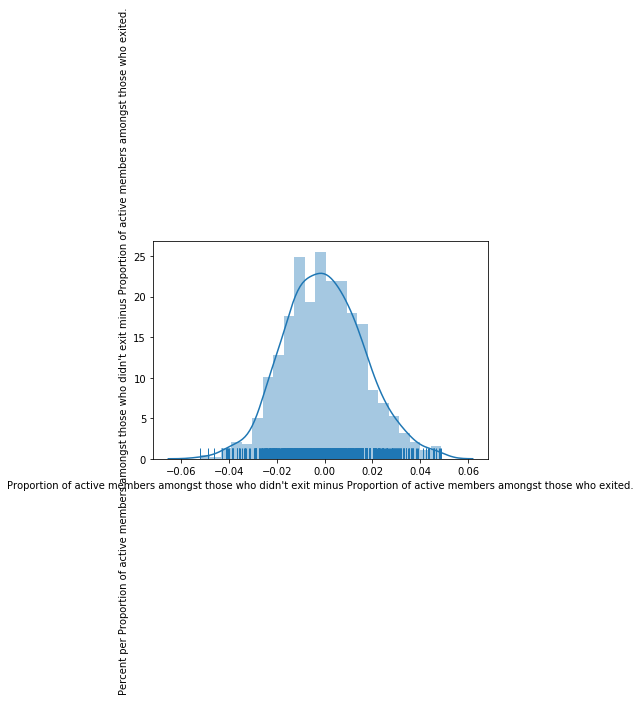

In [153]:
num_iterations = 1000
simulated_test_statistic_values = np.empty(num_iterations)
for i in np.arange(num_iterations):
    shuffled_exited = churn.sample(len(churn), replace = False).iloc[:, 13].to_frame().reset_index(drop=True) #So index in the new table isn't matched accordingly.
    churn['Shuffled Exited'] = shuffled_exited['Exited']
    grouped_proportion_active_members = churn[['Shuffled Exited', 'IsActiveMember']].groupby('Shuffled Exited').agg(np.mean)
    simulated_test_statistic_value = grouped_proportion_active_members['IsActiveMember'][0] - grouped_proportion_active_members['IsActiveMember'][1]
    simulated_test_statistic_values[i] = simulated_test_statistic_value
simulated_test_statistic_values = pd.Series(simulated_test_statistic_values)
sns.distplot(simulated_test_statistic_values, kde = True, rug = True)
plt.xlabel("Proportion of active members amongst those who didn't exit minus Proportion of active members amongst those who exited.")
plt.ylabel("Percent per Proportion of active members amongst those who didn't exit minus Proportion of active members amongst those who exited.")

In [154]:
p_value = np.count_nonzero(simulated_test_statistic_values >= observed_difference)/len(simulated_test_statistic_values)
p_value

0.0

With a small p-value of 0.0, which is less than the p-value cutoff of 0.05, we reject the null hypothesis. There is sufficient evidence to conclude that the active members amongst those who exited(closed their bank accounts) and the active members amongst those who did not exit(didn't close their bank accounts) come from different distributions. The proportion of active members of those who didn't close their bank accounts is greater than the proportion of active members of those who closed their bank accounts in the population of customer churn in this bank.

Could it be that proportion of those who have cr card amongst those who closed their bank account is different from the proportion of those who have cr card amongst those who didn't close their bank account?

In [155]:
cr_card = churn[['Exited', 'HasCrCard']].groupby('Exited', as_index = False).agg(np.mean)
cr_card

,Exited,HasCrCard
0,0,0.706040
1,1,0.692857


There doesn't appear to be a significant difference in proportion of those exited who have a CR card and those who didn't exit and have a CR card.

Could it be that average number of the bank's products used amongst those who closed their bank account is different from average number of the bank's products used amongst those who didn't close their bank account?

In [156]:
products = churn[['Exited', 'NumOfProducts']].groupby('Exited', as_index = False).agg(np.mean)
products

,Exited,NumOfProducts
0,0,1.543792
1,1,1.468831


In [157]:
observed_difference = products['NumOfProducts'][0] - products['NumOfProducts'][1]
observed_difference

0.07496077747755603

Null Hypothesis: The number of bank products used amongst those who exited of those who exited(closed their bank accounts) and active members for those who did not exit(didn't close their bank accounts) come from the same underlying distribution. There is no difference average in number of bank products used between those who closed their bank accounts and didn't close their bank accounts in the population of customer churn in this bank.

Alternative Hypothesis: The number of bank products used amongst those who exited(closed their bank accounts) and the number of bank products used amongst those who did not exit(didn't close their bank accounts) come from different distributions. The average number of bank products used of those who didn't closed their bank accounts is greater than average number of bank products used of those who closed their bank accounts in the population of customer churn in this bank.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Text(0, 0.5, "Percent per Average number of products used amongst those who didn't exit minus average number of products used amongst those who exited.")

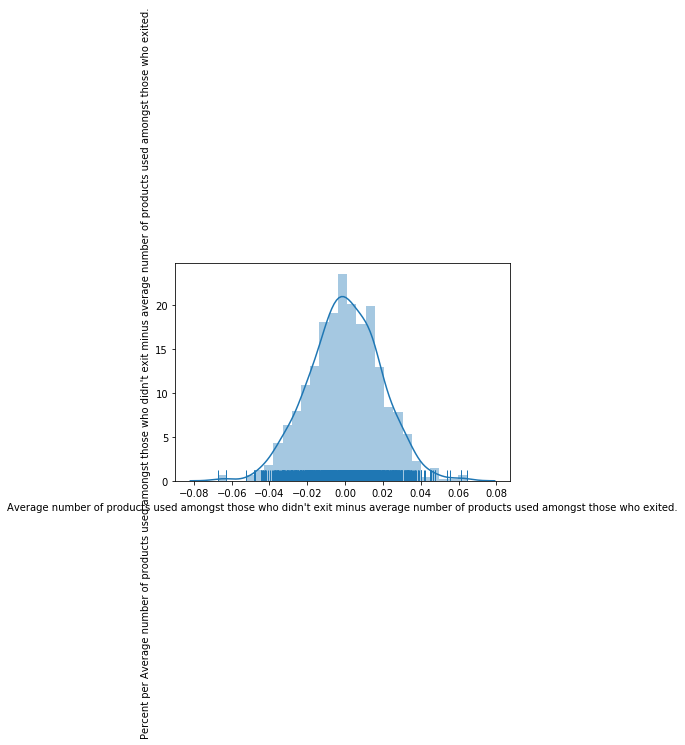

In [158]:
num_iterations = 1000
simulated_test_statistic_values = np.empty(num_iterations)
for i in np.arange(num_iterations):
    shuffled_exited = churn.sample(len(churn), replace = False).iloc[:, 13].to_frame().reset_index(drop=True) #So index in the new table isn't matched accordingly.
    churn['Shuffled Exited'] = shuffled_exited['Exited']
    grouped_average_num_products = churn[['Shuffled Exited', 'NumOfProducts']].groupby('Shuffled Exited').agg(np.mean)
    simulated_test_statistic_value = grouped_average_num_products['NumOfProducts'][0] - grouped_average_num_products['NumOfProducts'][1]
    simulated_test_statistic_values[i] = simulated_test_statistic_value
simulated_test_statistic_values = pd.Series(simulated_test_statistic_values)
sns.distplot(simulated_test_statistic_values, kde = True, rug = True)
plt.xlabel("Average number of products used amongst those who didn't exit minus average number of products used amongst those who exited.")
plt.ylabel("Percent per Average number of products used amongst those who didn't exit minus average number of products used amongst those who exited.")

In [164]:
p_value = np.count_nonzero(simulated_test_statistic_values >= observed_difference)/len(simulated_test_statistic_values)
p_value

0.146

With a small p-value of 0.146 which is greater than the p-value cutoff of 0.05, we fail to reject the null hypothesis. There is sufficient evidence to conclude that the number of bank products used amongst those who exited of those who exited(closed their bank accounts) and active members for those who did not exit(didn't close their bank accounts) come from the same underlying distribution. There is no difference average in number of bank products used between those who closed their bank accounts and didn't close their bank accounts in the population of customer churn in this bank.

Could there be a difference in the average tenure amongst those who exited and those who didnt?

In [160]:
tenure = churn[['Exited', 'Tenure']].groupby('Exited', as_index = False).agg(np.mean)
tenure

,Exited,Tenure
0,0,5.018121
1,1,4.905844


In [161]:
observed_difference = tenure['Tenure'][0] - tenure['Tenure'][1]
observed_difference

0.11227664952497207

Null Hypothesis: The tenure amongst those who exited of those who exited(closed their bank accounts) and active members for those who did not exit(didn't close their bank accounts) come from the same underlying distribution. There is no difference in average tenure between those who closed their bank accounts and didn't close their bank accounts in the population of customer churn in this bank.

Alternative Hypothesis: The tenure amongst those who exited(closed their bank accounts) and the tenure amongst those who did not exit(didn't close their bank accounts) come from different distributions. The average tenure amongst those who didn't close their bank accounts is greater than the average tenure of those who closed their bank accounts in the population of customer churn in this bank.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Text(0, 0.5, "Percent per Average tenure amongst those who didn't exit minus average tenure amongst those who exited.")

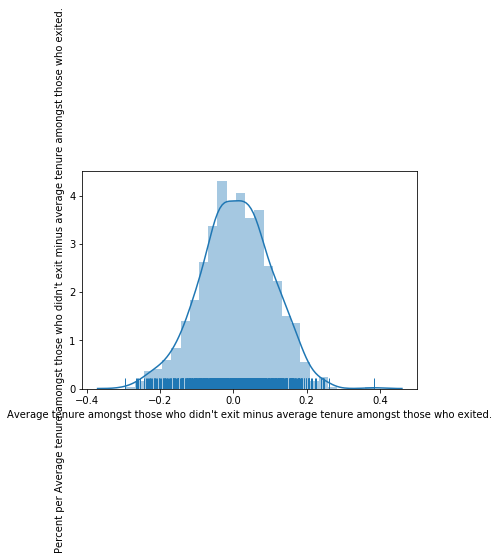

In [162]:
num_iterations = 1000
simulated_test_statistic_values = np.empty(num_iterations)
for i in np.arange(num_iterations):
    shuffled_exited = churn.sample(len(churn), replace = False).iloc[:, 13].to_frame().reset_index(drop=True) #So index in the new table isn't matched accordingly.
    churn['Shuffled Exited'] = shuffled_exited['Exited']
    grouped_tenure = churn[['Shuffled Exited', 'Tenure']].groupby('Shuffled Exited').agg(np.mean)
    simulated_test_statistic_value = grouped_tenure['Tenure'][0] - grouped_tenure['Tenure'][1]
    simulated_test_statistic_values[i] = simulated_test_statistic_value
simulated_test_statistic_values = pd.Series(simulated_test_statistic_values)
sns.distplot(simulated_test_statistic_values, kde = True, rug = True)
plt.xlabel("Average tenure amongst those who didn't exit minus average tenure amongst those who exited.")
plt.ylabel("Percent per Average tenure amongst those who didn't exit minus average tenure amongst those who exited.")

In [165]:
p_value = np.count_nonzero(simulated_test_statistic_values >= observed_difference)/len(simulated_test_statistic_values)
p_value

0.146

With a small p-value of 0.146 which is greater than the p-value cutoff of 0.05, we fail to reject the null hypothesis. The tenure amongst those who exited(closed their bank accounts) and the tenure amongst those who did not exit(didn't close their bank accounts) come from different distributions. The average tenure amongst those who didn't close their bank accounts is greater than the average tenure of those who closed their bank accounts in the population of customer churn in this bank.

**Model Development Phase for Predicting Customer Churn**

In [ ]:
def normalize_age(row):
    return (row-np.mean(churn['Age']))/np.std(churn['Age'])
def normalize_active_member(row):
    return (row-np.mean(churn['IsActiveMember']))/np.std(churn['IsActiveMember'])
def normalize_bank_products(row):
    return (row-np.mean(churn['NumOfProducts']))/np.std(churn['NumOfProducts'])
def normalize_age2(row):
    return (row-np.mean(churn_test['Age']))/np.std(churn_test['Age'])
def normalize_active_member2(row):
    return (row-np.mean(churn_test['IsActiveMember']))/np.std(churn_test['IsActiveMember'])
def normalize_bank_products2(row):
    return (row-np.mean(churn_test['NumOfProducts']))/np.std(churn_test['NumOfProducts'])

churn['AgeNormalized'] = churn['Age'].apply(normalize_age)
churn['ActiveMemberNormalized'] = churn['IsActiveMember'].apply(normalize_active_member)
churn['BankProductsNormalized'] = churn['NumOfProducts'].apply(normalize_bank_products)
churn_test['AgeNormalized'] = churn_test['Age'].apply(normalize_age2)
churn_test['ActiveMemberNormalized'] = churn_test['IsActiveMember'].apply(normalize_active_member2)
churn_test['BankProductsNormalized'] = churn_test['NumOfProducts'].apply(normalize_bank_products2)

In [ ]:
#Model Development Phase
churn = churn.loc[:, ['AgeNormalized', 'ActiveMemberNormalized', 'BankProductsNormalized', 'Exited']]
churn_y = churn.loc[:, 'Exited']
churn = churn.loc[:, ['AgeNormalized', 'ActiveMemberNormalized', 'BankProductsNormalized']]
churn

In [ ]:
#Model Development Phase
churn_test = churn_test.loc[:, ['AgeNormalized', 'ActiveMemberNormalized', 'BankProductsNormalized', 'Exited']]
churn_test_y = churn_test.loc[:, 'Exited']
churn_test = churn_test.loc[:, ['AgeNormalized', 'ActiveMemberNormalized', 'BankProductsNormalized']]

K Nearest Neighbors Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(churn, churn_y)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
training_scores = cross_val_score(neigh, churn, churn_y, cv=5)
print(training_scores)

average_cv_training1 = np.mean(training_scores)
accuracy_on_test_set1 = neigh.score(churn_test, churn_test_y)
average_cv_training1, accuracy_on_test_set1

Logistic Regression Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0).fit(churn, churn_y)
print(lr.score(churn, churn_y))

In [ ]:
training_scores = cross_val_score(lr, churn, churn_y, cv = 5)
print(training_scores)
average_cv_training2 = np.mean(training_scores)
accuracy_on_test_set2 = lr.score(churn_test, churn_test_y)
average_cv_training2, accuracy_on_test_set2

Decision Tree Classifier

In [ ]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt.fit(churn, churn_y)
print(dt.score(churn, churn_y))

In [ ]:
training_scores = cross_val_score(dt, churn, churn_y, cv = 5)
print(training_scores)
average_cv_training3 = np.mean(training_scores)
accuracy_on_test_set3 = dt.score(churn_test, churn_test_y)
average_cv_training3, accuracy_on_test_set3

Gaussian Naive Bayesian Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(churn, churn_y)
print(gnb.score(churn, churn_y))

In [ ]:
training_scores = cross_val_score(gnb, churn, churn_y, cv = 5)
print(training_scores)
average_cv_training4 = np.mean(training_scores)
accuracy_on_test_set4 = gnb.score(churn_test, churn_test_y)
average_cv_training4, accuracy_on_test_set4

Random Forest Ensemble Model of Multiple Weak Learning Decision Trees

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC #Combining multiple weak learners(multiple decision trees) to make a strong learner(wisdom of the crowd)
rfc_b = RFC()
rfc_b.fit(churn, churn_y)
y_pred = rfc_b.predict(churn)
y_pred

In [ ]:
training_scores = cross_val_score(rfc_b, churn, churn_y, cv = 5)
print(training_scores)
average_cv_training5 = np.mean(training_scores)
accuracy_on_test_set5 = clf.score(churn_test, churn_test_y)
average_cv_training5, accuracy_on_test_set5

Support Vector Machine

In [ ]:
from sklearn import svm
clf = svm.SVC()
clf.fit(churn, churn_y)
print(clf.score(churn, churn_y))

In [ ]:
training_scores = cross_val_score(clf, churn, churn_y, cv = 5)
print(training_scores)
average_cv_training6 = np.mean(training_scores)
accuracy_on_test_set6 = clf.score(churn_test, churn_test_y)
average_cv_training6, accuracy_on_test_set6

In [ ]:
objects = ('KNN', 'Logistic Regression', 'Decision Tree', 'Gaussian Naive Bayesian', 'Random Forest', 'SVM')
y_pos = np.arange(len(objects))
performance = [accuracy_on_test_set1, accuracy_on_test_set2, accuracy_on_test_set3, accuracy_on_test_set4, accuracy_on_test_set5, accuracy_on_test_set6]
plt.bar(y_pos, performance, align='center', alpha=0.5) 
plt.xticks(y_pos, objects)
plt.xticks(rotation= 45)
plt.ylabel('Accuracy on Test Set')
plt.title('Model')

In conclusion, Decision Tree, Random Forest Ensemble, and SVM models received the highest accuracies of 0.8588, 0.8568, and 0.8568 respectively on the test set for predicting bank client churn(whether a particular client will close their bank account or not). Thus, these models(after further testing with unseen data) will likely be used in a production environment. We must proceed with caution however, as trends in the factors that affect customer churn may change over time, so we will need to update the model with new data over time to make these predictions align with the trends. Additionally, investigation into potential model drift over time should be examined, and should be trained with new and updated data.